# Telemarketing Campaign Study

# Overview


We're going to look at a larger dataset from a **banking marketing campaign**. Specifically, it was a telemarketing campaign where the telemarketers contacted existing customers to try and get them to subscribe to a bank term deposit.

From all the customers contacted, some agreed and some didn't. In some cases, contacting the same customer multiple times resulted in an eventual agreement. The dataset contains many rows of data, some of which are useful and some are not.

# Brief

**The objective** is to try and **classify whether a customer will agree or not to take a bank term deposit** based on what we know about them, and maybe use the same model to predict the successfulness of a campaign in the future.

# Import librairies

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
import researchpy as rp
from IPython.display import Image  
import pydotplus
%matplotlib inline

# Loading data

In [36]:
df = pd.read_csv('./datasets/bank-data.csv')
df.shape

(11162, 18)

In [37]:
df.head()

,Unnamed: 0,age,job,maritalStatus,education,defaultedCredit,balance,housingLoan,personalLoan,contactType,day_of_month,month,callDuration,numberTimesContactedInCampaign,daysSinceLastContact,totalTimesContacted,outcomeLastCampaign,subscribed
0,1,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,2,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,3,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,4,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,5,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.describe()

,Unnamed: 0,age,balance,day_of_month,callDuration,numberTimesContactedInCampaign,daysSinceLastContact,totalTimesContacted
count,11162.000000,11162.000000,9475.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5581.500000,41.231948,1824.106385,15.658036,371.993818,2.508421,51.330407,0.832557
std,3222.336187,11.913369,3414.744888,8.420740,347.128386,2.722077,108.758282,2.292007
min,1.000000,18.000000,10.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,2791.250000,32.000000,282.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,5581.500000,39.000000,771.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,8371.750000,49.000000,2071.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,11162.000000,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 18 columns):
Unnamed: 0                        11162 non-null int64
age                               11162 non-null int64
job                               11162 non-null object
maritalStatus                     11162 non-null object
education                         11162 non-null object
defaultedCredit                   11162 non-null object
balance                           9475 non-null float64
housingLoan                       11162 non-null object
personalLoan                      11162 non-null object
contactType                       11162 non-null object
day_of_month                      11162 non-null int64
month                             11162 non-null object
callDuration                      11162 non-null int64
numberTimesContactedInCampaign    11162 non-null int64
daysSinceLastContact              11162 non-null int64
totalTimesContacted               11162 non-null int64
ou

Some **null** values in **balance**.

In [31]:
categorical_columns = [df.columns[i] for i, dtype in enumerate(df.dtypes) if str(dtype)=='object']
for cat in categorical_columns:
    print('"{}" unique values: \n\t{}\n'.format(cat, df[cat].unique()))

"job" unique values: 
	['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']

"maritalStatus" unique values: 
	['married' 'single' 'divorced']

"education" unique values: 
	['secondary' 'tertiary' 'primary' 'unknown']

"defaultedCredit" unique values: 
	['no' 'yes']

"housingLoan" unique values: 
	['yes' 'no']

"personalLoan" unique values: 
	['no' 'yes']

"contactType" unique values: 
	['unknown' 'cellular' 'telephone']

"month" unique values: 
	['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

"outcomeLastCampaign" unique values: 
	['unknown' 'other' 'failure' 'success']

"subscribed" unique values: 
	['yes' 'no']



Apparently all categorical values seem to be fine.

In [32]:
df.subscribed.describe()

count     11162
unique        2
top          no
freq       5873
Name: subscribed, dtype: object

In [33]:
(5873/11162, (11162-5873)/11162)

(0.5261601863465328, 0.4738398136534671)

From the previous cell we understand that our binary class "subscribed" **is well balanced with 53% NO and 47% YES**.

#  Data cleaning

In [38]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.dropna()
df.describe()

,age,balance,day_of_month,callDuration,numberTimesContactedInCampaign,daysSinceLastContact,totalTimesContacted
count,9475.000000,9475.000000,9475.000000,9475.000000,9475.000000,9475.000000,9475.000000
mean,41.284433,1824.106385,15.558100,373.589974,2.459208,53.755251,0.881794
std,12.129806,3414.744888,8.395232,346.923923,2.618663,110.447887,2.373007
min,18.000000,10.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,282.000000,8.000000,140.000000,1.000000,-1.000000,0.000000
50%,39.000000,771.000000,15.000000,258.000000,2.000000,-1.000000,0.000000
75%,49.000000,2071.000000,21.000000,493.000000,3.000000,85.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


# Age factor analysis

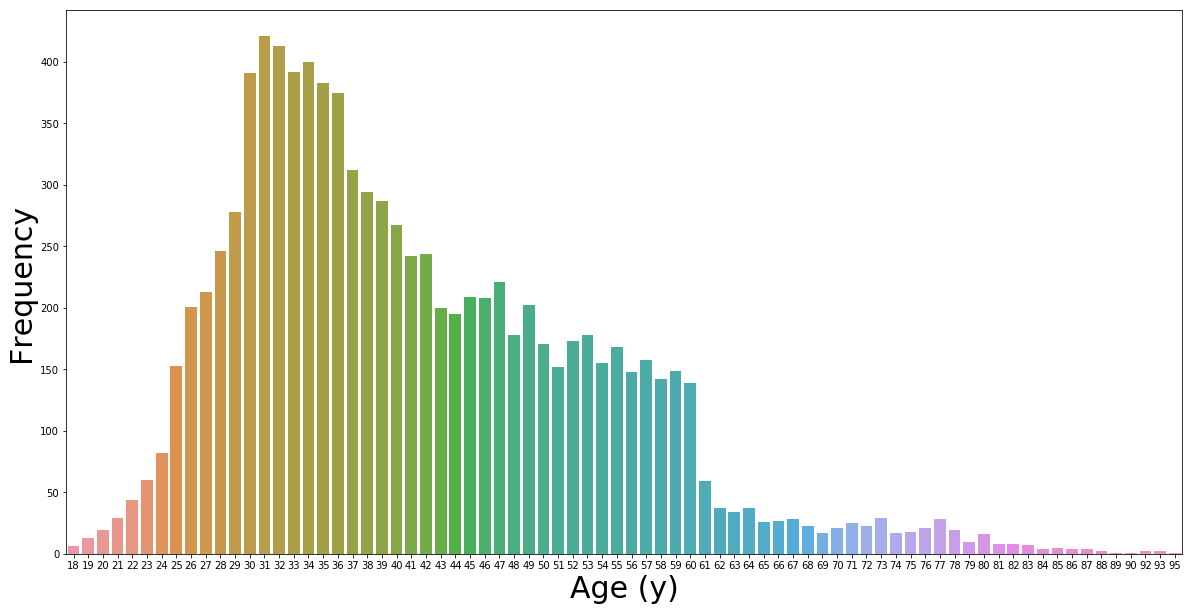

In [41]:
# let's draw a barplot of age
plt.figure(figsize=(20, 10))
fig1 = sns.countplot(x='age', data=df)
fig1.set_xlabel("Age (y)", fontsize=30)
fig1.set_ylabel("Frequency", fontsize=30)
plt.show()

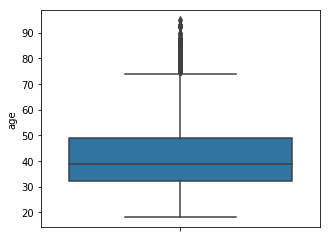

In [48]:
# let's draw a boxplot to see the variation of age
plt.figure(figsize=(5, 4))
fig2 = sns.boxplot(y='age', data=df)
plt.show()

There are quite a few outliers above 75 yo, these are likely to not take a term deposit and therefore may affect our results.

But for now we won't remove any records.

# Feature analysis

Now that we have a good understanding of the dataset we are going to be working on, it is time to look further into how the features of the data relate to the output - the subscription feature.

## Graphical analysis

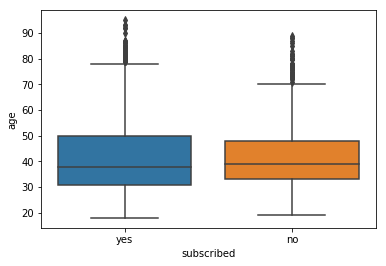

In [49]:
# let's draw a boxplot of age based on whether the telecampaing was succesful or not
sns.boxplot(y='age', x ='subscribed', data=df)
plt.show()

It seems older people are more likely to respond positively to a telemarketing campaign than negatively.

In [54]:
# subset of the dataset consifering people younger than 60
younger = df.loc[df.age<60]
younger[['age']].describe()

,age
count,8772.000000
mean,39.130643
std,9.574688
min,18.000000
25%,32.000000
50%,37.000000
75%,47.000000
max,59.000000


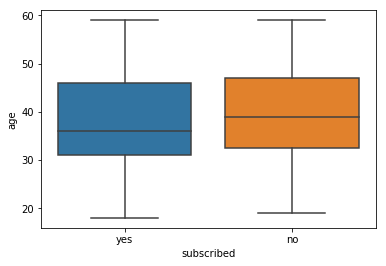

In [56]:
# let's draw a boxplot of age based on whether the telecampaing was succesful or not; only for people younger than 60
sns.boxplot(y='age', x ='subscribed', data=younger)
plt.show()

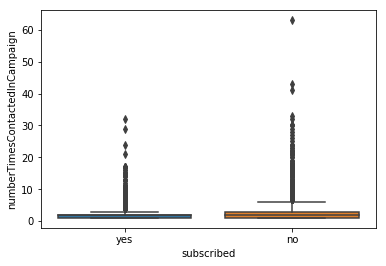

In [57]:
# let's look at the relationship between number of calls and the subscription outcome
sns.boxplot(y='numberTimesContactedInCampaign', x ='subscribed', data=df)
plt.show()

Increasing the number of calls doesn't seem to be conducive to subscriptions.

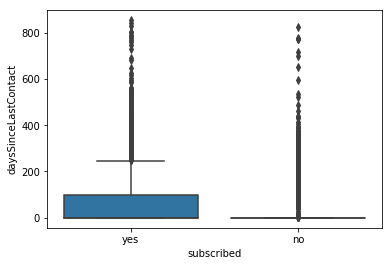

In [58]:
# let's look at the relationship between number of days since the last contact and the subscription outcome
sns.boxplot(y='daysSinceLastContact', x ='subscribed', data=df)
plt.show()

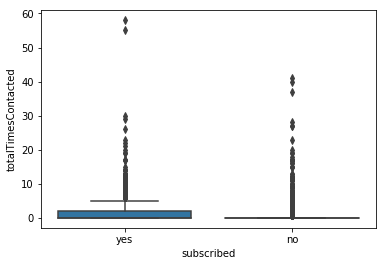

In [59]:
# let's look at the relationship between total times contacted and the subscription outcome
sns.boxplot(y='totalTimesContacted', x ='subscribed', data=df)
plt.show()

Age and daysSinceLastContact seems to be good predictors of whether a subscription will be successful.

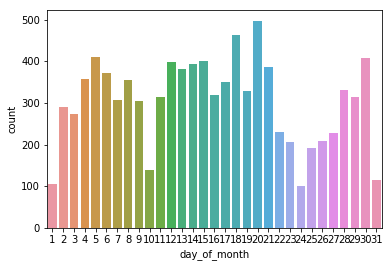

In [61]:
# let's look at the distribution of calls during each month
sns.countplot(x='day_of_month',data=df)
plt.show()

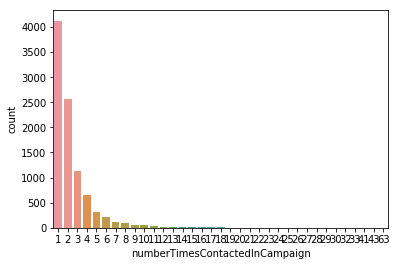

In [62]:
# let's look at the distribution of the number of times people were contacted
sns.countplot(x='numberTimesContactedInCampaign',data=df)
plt.show()

The distribution of calls doesn't see to be fair, not all person interviewed have had the same treatment.

## Tabulated analysis

In [63]:
# let's look at differences in subscription rates and different jobs
pd.crosstab(df['job'], df['subscribed'])

subscribed,no,yes
job,,
admin.,569,560
blue-collar,981,603
entrepreneur,170,97
housemaid,137,98
management,1024,1186
retired,222,473
self-employed,182,163
services,453,308
student,83,254


Retired people seem more likely to subscribe.

In [64]:
# let's look at differences in subscription rates and marital status
pd.crosstab(df['maritalStatus'], df['subscribed'])

subscribed,no,yes
maritalStatus,,
divorced,510,512
married,2902,2455
single,1363,1733


Single people seem more likely to subscribe, married people seem more unlikely to subscribe.

In [65]:
# let's look at differences in subscription rates and education
pd.crosstab(df['education'], df['subscribed'])

subscribed,no,yes
education,,
primary,718,520
secondary,2459,2151
tertiary,1392,1787
unknown,206,242


Higher level of education seem to be conducive to subscriptions.

In [66]:
# let's look at differences in subscription rates and housing loan
pd.crosstab(df['housingLoan'], df['subscribed'])

subscribed,no,yes
housingLoan,,
no,2083,3074
yes,2692,1626


Mortgage free people are much more likely to subscribe.

## Tabulated graphical analysis

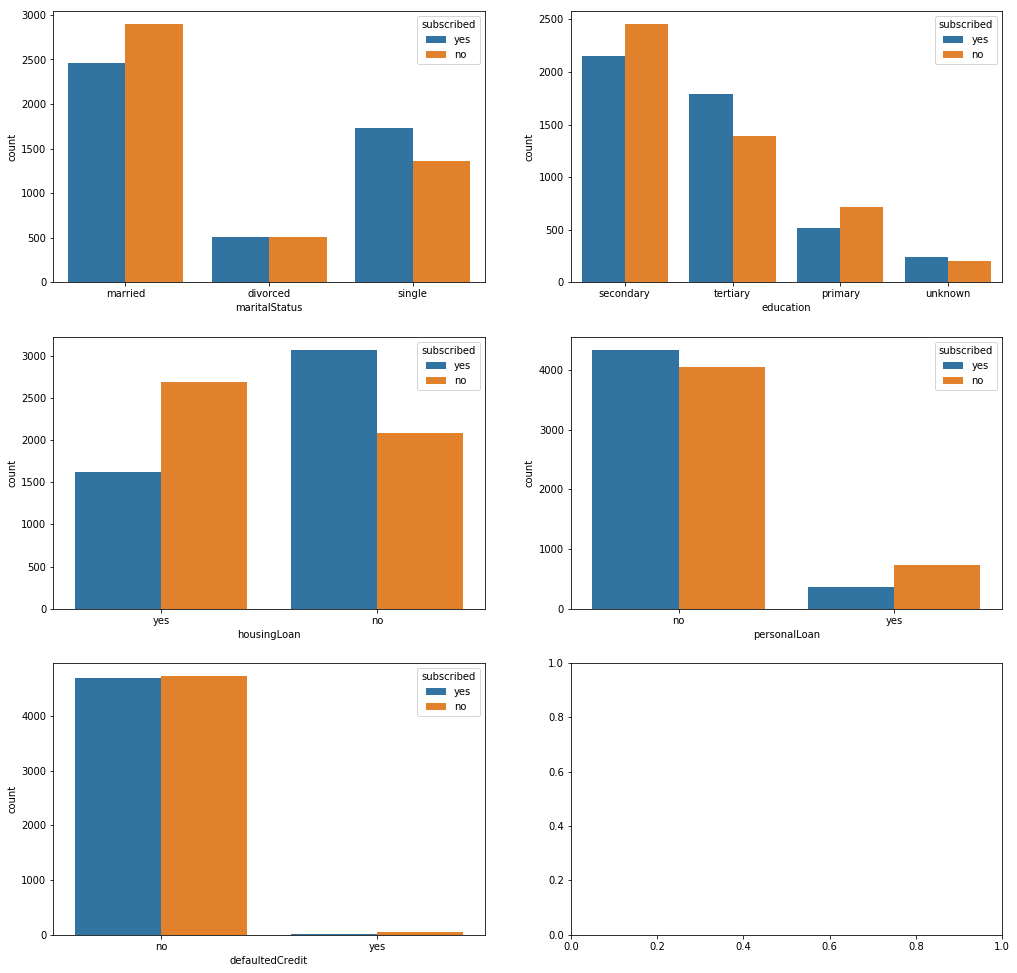

In [67]:
f, axes = plt.subplots(3, 2, figsize=(17, 17))
sns.countplot(x='maritalStatus', hue='subscribed', data=df, ax=axes[0,0])
sns.countplot(x='education', hue='subscribed', data=df, ax=axes[0,1])
sns.countplot(x='housingLoan', hue='subscribed', data=df, ax=axes[1,0])
sns.countplot(x='personalLoan', hue='subscribed', data=df, ax=axes[1,1])
sns.countplot(x='defaultedCredit', hue='subscribed', data=df, ax=axes[2,0])
plt.show()

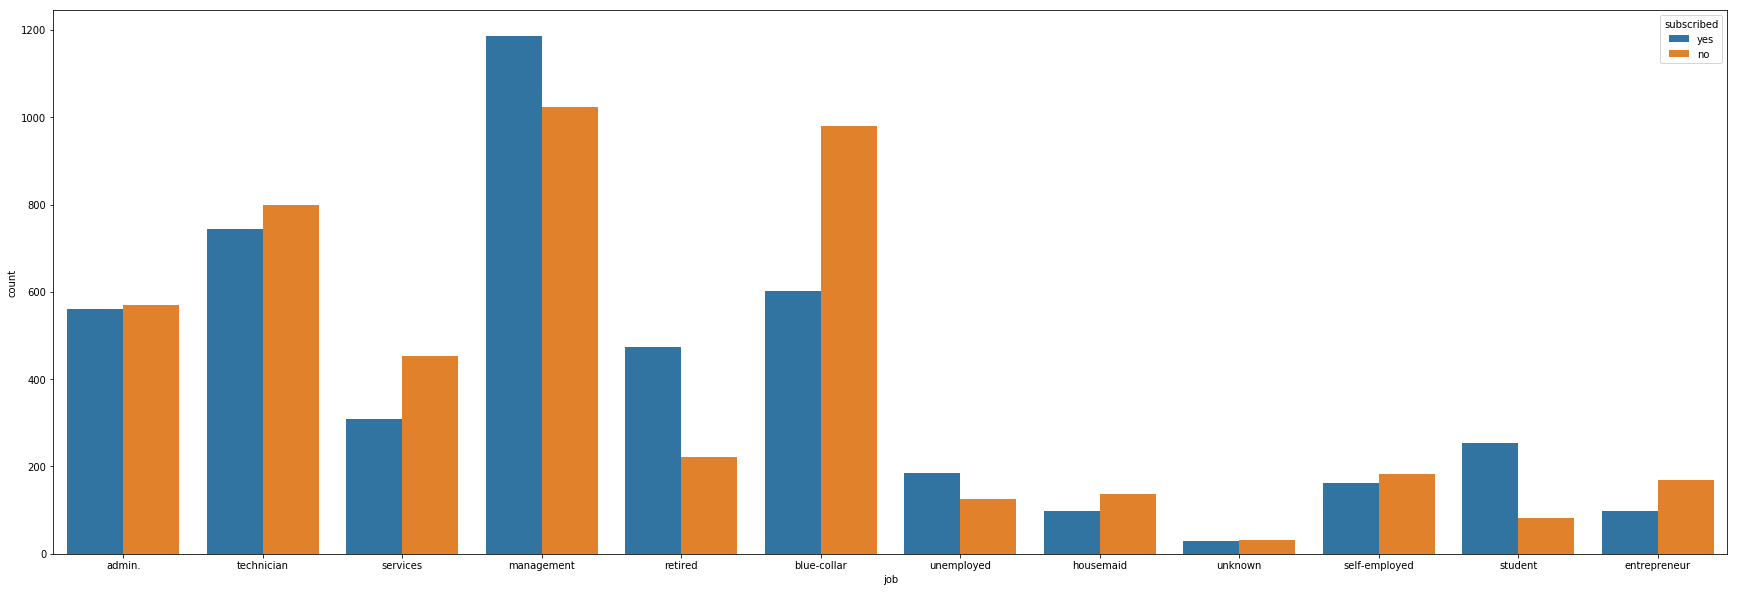

In [68]:
fig3 = sns.countplot(x='job', hue='subscribed', data=df)
fig3.figure.set_size_inches(30,10)
plt.show()

You are looking here at very heavily skewed data.

If we have too much data leaning one way or the other, then it means we have a heavily weighted dataset and that can seriously affect our results.

From the above graphical analysis, if any of the variables stand out as heavily skewed, perhaps we should remove them.

# Correlation analysis

There is one last important step we need to do before building our classification model.

We have visualised the data now in many different ways and seen that there are outliers.

In order to see the bigger picture, it will be necessary to remove some of the outlier points, or at least run the model with/and without them and compare the models.

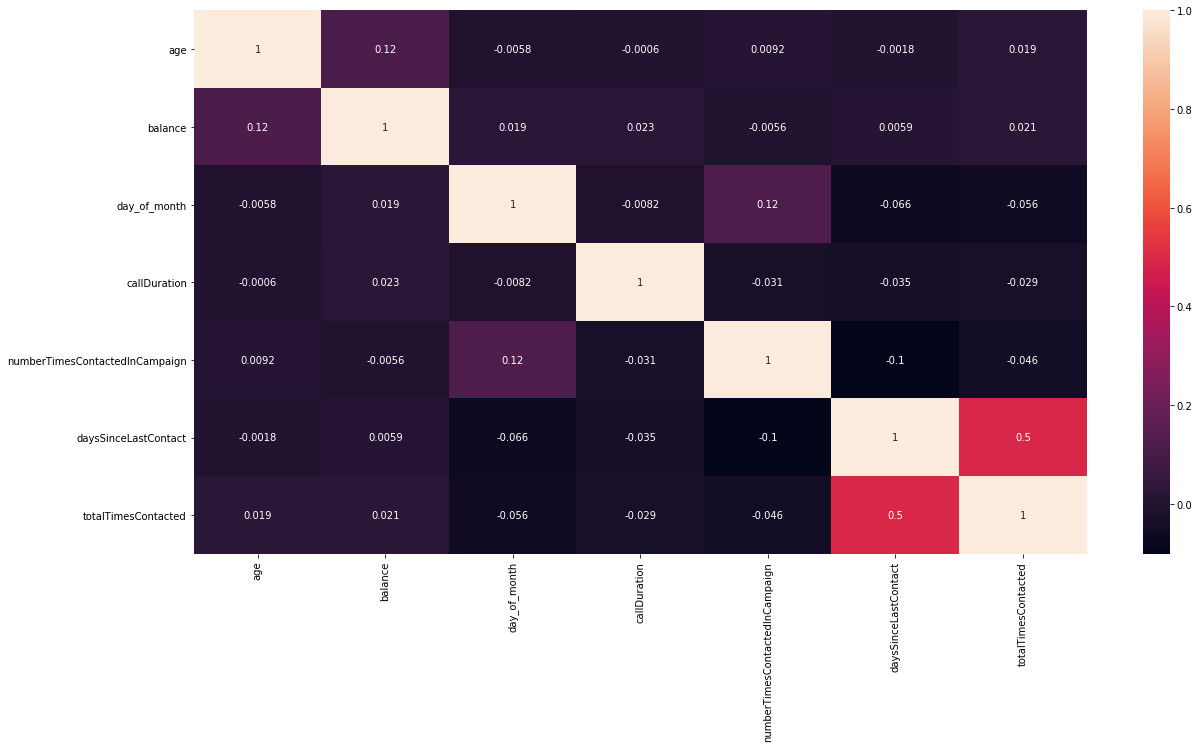

In [69]:
# One part is checking the correlation of numerical variables to do that we can use the function`.heatmap` from `sns` library
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(),  annot=True)

### Dummy variables
Sometimes to evaluate the correlartion of categorical variables it is necessary to create dummy variables. One for each level of a categorical variable.

In [70]:
# new data set with dummy variables
cor_data = pd.get_dummies(df)
cor_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9475 entries, 0 to 11159
Data columns (total 53 columns):
age                               9475 non-null int64
balance                           9475 non-null float64
day_of_month                      9475 non-null int64
callDuration                      9475 non-null int64
numberTimesContactedInCampaign    9475 non-null int64
daysSinceLastContact              9475 non-null int64
totalTimesContacted               9475 non-null int64
job_admin.                        9475 non-null uint8
job_blue-collar                   9475 non-null uint8
job_entrepreneur                  9475 non-null uint8
job_housemaid                     9475 non-null uint8
job_management                    9475 non-null uint8
job_retired                       9475 non-null uint8
job_self-employed                 9475 non-null uint8
job_services                      9475 non-null uint8
job_student                       9475 non-null uint8
job_technician            

### Correlation matrix

In [71]:
cor_matrix = cor_data.corr()

In [73]:
cor_matrix.shape

(53, 53)

In [75]:
cor_matrix.head()

,age,balance,day_of_month,callDuration,numberTimesContactedInCampaign,daysSinceLastContact,totalTimesContacted,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,outcomeLastCampaign_failure,outcomeLastCampaign_other,outcomeLastCampaign_success,outcomeLastCampaign_unknown,subscribed_no,subscribed_yes
age,1.000000,0.120153,-0.005764,-0.000602,0.009153,-0.001839,0.019463,-0.056782,-0.056703,0.022192,...,-0.117543,0.015472,0.061690,0.037255,-0.010632,-0.026816,0.058651,-0.019908,-0.032704,0.032704
balance,0.120153,1.000000,0.018799,0.022507,-0.005632,0.005932,0.020625,-0.041971,-0.041017,0.010524,...,-0.054380,0.076856,0.022384,0.014929,-0.004409,0.025538,0.029398,-0.029796,-0.063845,0.063845
day_of_month,-0.005764,0.018799,1.000000,-0.008201,0.122258,-0.066454,-0.055504,-0.011646,-0.016275,-0.011625,...,0.001725,0.067028,0.081455,-0.079072,-0.055576,-0.013180,-0.040488,0.074274,0.050770,-0.050770
callDuration,-0.000602,0.022507,-0.008201,1.000000,-0.030996,-0.035050,-0.028761,-0.028002,0.031970,-0.007237,...,0.017575,-0.007487,-0.019833,-0.007924,-0.041890,-0.009975,-0.028098,0.054325,-0.430231,0.430231
numberTimesContactedInCampaign,0.009153,-0.005632,0.122258,-0.030996,1.000000,-0.101746,-0.046383,-0.014612,0.012705,0.023964,...,-0.018202,-0.076390,-0.070907,-0.052728,-0.078315,-0.022309,-0.093224,0.131591,0.130536,-0.130536


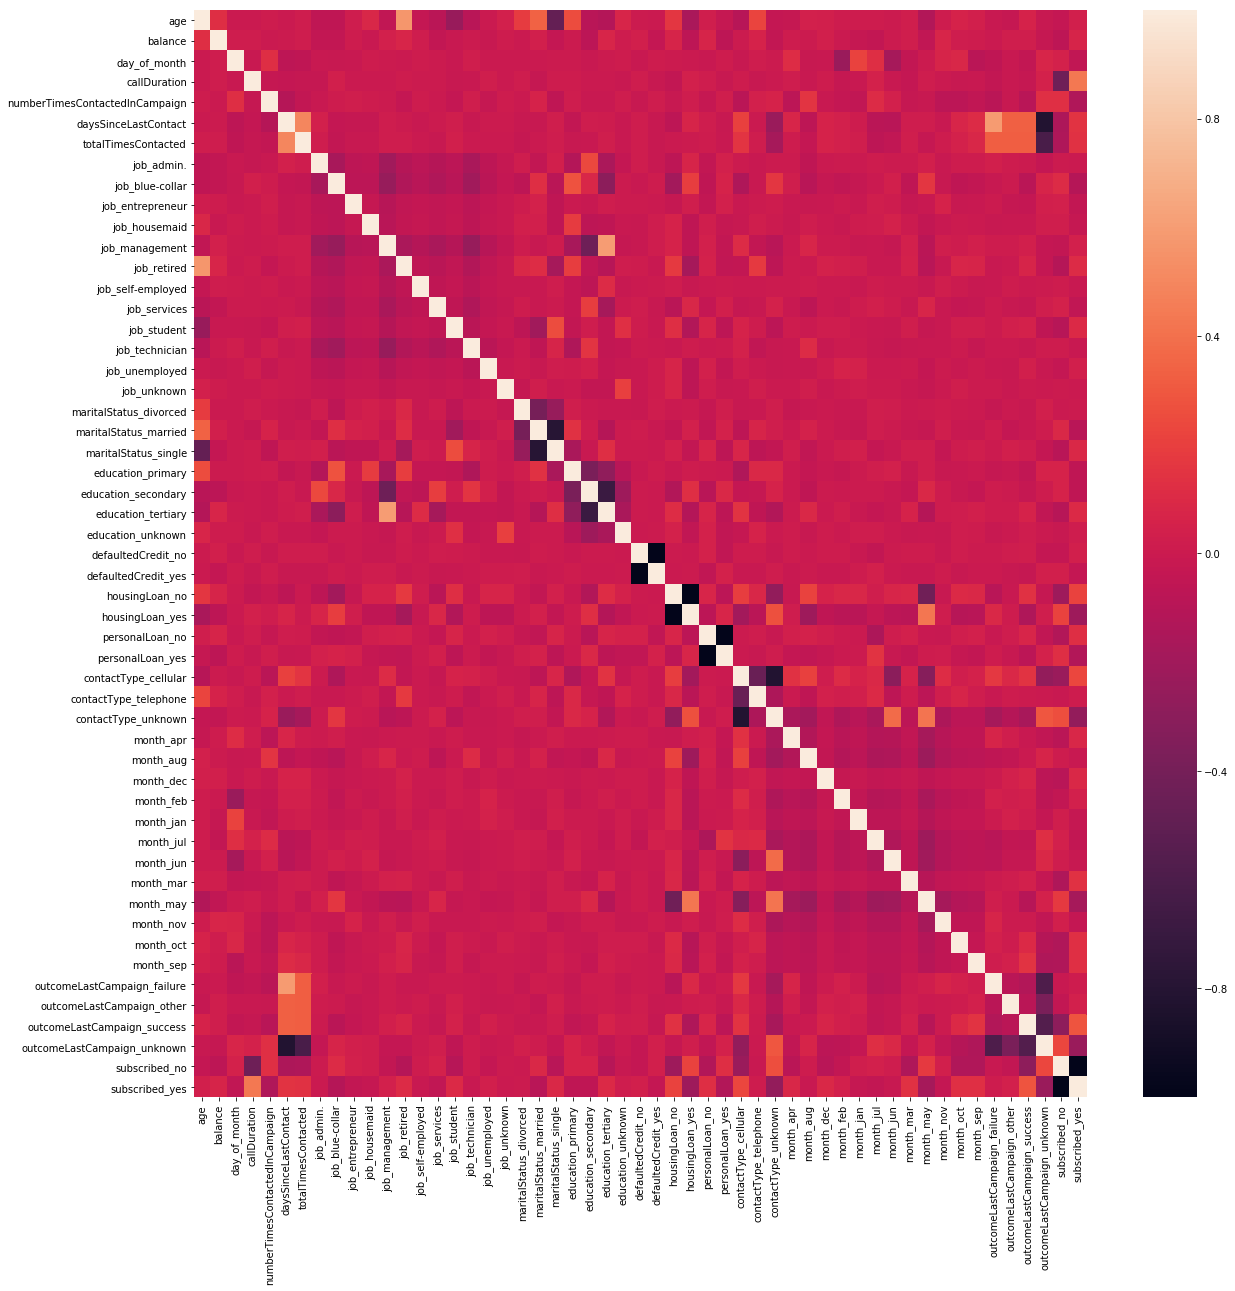

In [77]:
plt.figure(figsize=(20, 20))
sns.heatmap(cor_matrix)

In [84]:
cor_matrix.subscribed_yes.sort_values(ascending=False)[:5]

subscribed_yes                 1.000000
callDuration                   0.430231
outcomeLastCampaign_success    0.287807
contactType_cellular           0.228386
housingLoan_no                 0.218664
Name: subscribed_yes, dtype: float64

In [85]:
cor_matrix.subscribed_yes.sort_values(ascending=True)[:5]

subscribed_no                 -1.000000
contactType_unknown           -0.263310
outcomeLastCampaign_unknown   -0.228501
housingLoan_yes               -0.218664
month_may                     -0.175494
Name: subscribed_yes, dtype: float64

In [86]:
cor_matrix.subscribed_no.sort_values(ascending=False)[:5]

subscribed_no                  1.000000
contactType_unknown            0.263310
outcomeLastCampaign_unknown    0.228501
housingLoan_yes                0.218664
month_may                      0.175494
Name: subscribed_no, dtype: float64

In [87]:
cor_matrix.subscribed_no.sort_values(ascending=True)[:5]

subscribed_yes                -1.000000
callDuration                  -0.430231
outcomeLastCampaign_success   -0.287807
contactType_cellular          -0.228386
housingLoan_no                -0.218664
Name: subscribed_no, dtype: float64

**callDuration** has the highest positive correlation (after subscribed itself), but we can't use **callDuration** in our predictive classifier so **outcomeLastCampaign** seems the next best feature.

**contactType** has the highest negative correlation (after subscribed itself).

## Calculating _r_-coefficients and *p*-values

The p-value and the Pearson Correlation tests.

It's all very well being able to intuitively visualise correlation. However this is a data analysis course and one of the most important things is to be able to define accurately and statistically whether a correlation is significant or not. To test that, we are going to use Pearson correlation test, that allows us to calculate the probability that the current result was due to chance.

Remember during the introduction to statistics we talked about p-value and hypothesis testing; in this case we are going to ask whether the correlation that we are looking is due to chance or not. To do so we are going to calculate the p-value, which is the probability of observe the current result (in this case the r coefficient) given that there is no significant correlation. If that probability is tiny, then we could be sure that the correlation is significant and it is not due to chance. As you saw before a p-value less than 0.05 can be considered small enough to reject the hypothesis that the correlation is due to chance. The p-value is not related with the strength of the correlation. It only tell us whether a correlation is due to chance or not. Sometimes you can observe r coefficients very close to zero but which p-values that suggest that the correlation is not due to chance, in other cases r coefficients can be very large in magnitude (close to -1 or 1), but with non-significant p-values. In the last case that can happen when the correlation is caused by few outliers.

In [90]:
corr_type, corr_matrix, corr_ps = rp.corr_case(cor_data)

The function .corr_case generates three matrixes, one about the type of correlation, the second matrix shows the r coefficient and the last matrix shows the p-value of the correlation

In [91]:
corr_ps.head()

,age,balance,day_of_month,callDuration,numberTimesContactedInCampaign,daysSinceLastContact,totalTimesContacted,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,outcomeLastCampaign_failure,outcomeLastCampaign_other,outcomeLastCampaign_success,outcomeLastCampaign_unknown,subscribed_no,subscribed_yes
age,0.0000,0.0000,0.5748,0.9533,0.3730,0.8579,0.0582,0.0000,0.0000,0.0308,...,0.0000,0.1321,0.0000,0.0003,0.3008,0.0090,0.0000,0.0527,0.0015,0.0015
balance,0.0000,0.0000,0.0673,0.0285,0.5836,0.5637,0.0447,0.0000,0.0001,0.3057,...,0.0000,0.0000,0.0293,0.1462,0.6679,0.0129,0.0042,0.0037,0.0000,0.0000
day_of_month,0.5748,0.0673,0.0000,0.4247,0.0000,0.0000,0.0000,0.2570,0.1132,0.2579,...,0.8667,0.0000,0.0000,0.0000,0.0000,0.1996,0.0001,0.0000,0.0000,0.0000
callDuration,0.9533,0.0285,0.4247,0.0000,0.0025,0.0006,0.0051,0.0064,0.0019,0.4812,...,0.0871,0.4662,0.0535,0.4406,0.0000,0.3316,0.0062,0.0000,0.0000,0.0000
numberTimesContactedInCampaign,0.3730,0.5836,0.0000,0.0025,0.0000,0.0000,0.0000,0.1550,0.2163,0.0197,...,0.0764,0.0000,0.0000,0.0000,0.0000,0.0299,0.0000,0.0000,0.0000,0.0000


The function .corr_pair generates one matrix, where it shows for each pair of variables the r coefficient and the p-value of the correlation

With that outcome it is possible to check how many correlations are very high (r coefficient higher than 0.5 or lower than -0.5) and significant (p-value lower than 0.05)

In [92]:
corr_table = rp.corr_pair(cor_data)
corr_table.head(3)

,r value,p-value,N
age & balance,0.1202,0.0000,9475
age & day_of_month,-0.0058,0.5748,9475
age & callDuration,-0.0006,0.9533,9475


In [93]:
# the r value and p-value are not numeric values!
corr_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1378 entries, age & balance to subscribed_no & subscribed_yes
Data columns (total 3 columns):
r value    1378 non-null object
p-value    1378 non-null object
N          1378 non-null int64
dtypes: int64(1), object(2)
memory usage: 83.1+ KB


In [94]:
# usiong pd.to_numeric we can solve the problem
corr_table['p-value']= pd.to_numeric(corr_table['p-value'])
corr_table['r value']= pd.to_numeric(corr_table['r value'])

In [95]:
corr_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1378 entries, age & balance to subscribed_no & subscribed_yes
Data columns (total 3 columns):
r value    1378 non-null float64
p-value    1378 non-null float64
N          1378 non-null int64
dtypes: float64(2), int64(1)
memory usage: 83.1+ KB


In [96]:
corr_table.head()

,r value,p-value,N
age & balance,0.1202,0.0000,9475
age & day_of_month,-0.0058,0.5748,9475
age & callDuration,-0.0006,0.9533,9475
age & numberTimesContactedInCampaign,0.0092,0.3730,9475
age & daysSinceLastContact,-0.0018,0.8579,9475


In [97]:
corr_table[(corr_table['r value'] > 0.5)]

,r value,p-value,N
age & job_retired,0.5703,0.0,9475
daysSinceLastContact & outcomeLastCampaign_failure,0.5900,0.0,9475
job_management & education_tertiary,0.5965,0.0,9475


In [101]:
corr_table[(corr_table['r value']  < -0.5)]

,r value,p-value,N
daysSinceLastContact & outcomeLastCampaign_unknown,-0.8164,0.0,9475
totalTimesContacted & outcomeLastCampaign_unknown,-0.6121,0.0,9475
maritalStatus_married & maritalStatus_single,-0.7946,0.0,9475
education_secondary & education_tertiary,-0.6917,0.0,9475
defaultedCredit_no & defaultedCredit_yes,-1.0000,0.0,9475
housingLoan_no & housingLoan_yes,-1.0000,0.0,9475
personalLoan_no & personalLoan_yes,-1.0000,0.0,9475
contactType_cellular & contactType_unknown,-0.8169,0.0,9475
outcomeLastCampaign_failure & outcomeLastCampaign_unknown,-0.5889,0.0,9475
outcomeLastCampaign_success & outcomeLastCampaign_unknown,-0.5670,0.0,9475


On that basis we can say with confidence that those correlations are not due to chance.

# Classification model

We are going to implement the Random forest algorithm in `sklearn`. The first reason for this is that random forests work well when classifying binary data i.e two possible classes. In our dataset the classes are 'Yes' and 'No' for the subscribed data so it is indeed binary. The second reason is that we already implemented a decision tree during the workshop - by definition, a random forest is just a collection of decision trees, each trained on a random subsample of the dataset. Let's start by splitting the data!

In [110]:
# let's split the data into train and test data
x = cor_data[cor_data.columns[:-2]]
y = df.subscribed
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size = 0.25, random_state = 1234)

In this step we are going to set up the model with 500 trees, using entropy as the parameter to find the optimal tree and with a maximum depth of 5 nodes. Then we are going to train the model using the function `.fit`

In [111]:
clf = RandomForestClassifier(n_estimators=500, criterion = 'entropy', max_depth=5, random_state=1234)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [113]:
# evaluate the accuracy of the model by making predictions from the test data
y_pred = clf.predict(x_test)
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.7999155761924863


Text(91.68, 0.5, 'predicted values')

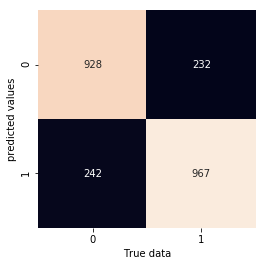

In [114]:
# y_test is a dataframe and to use the function confusion_matrix it is necessary to convert y_test to a list
from sklearn.metrics import confusion_matrix
y_true = y_test.tolist()
mat = confusion_matrix(y_true,y_pred)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True data')
plt.ylabel('predicted values')

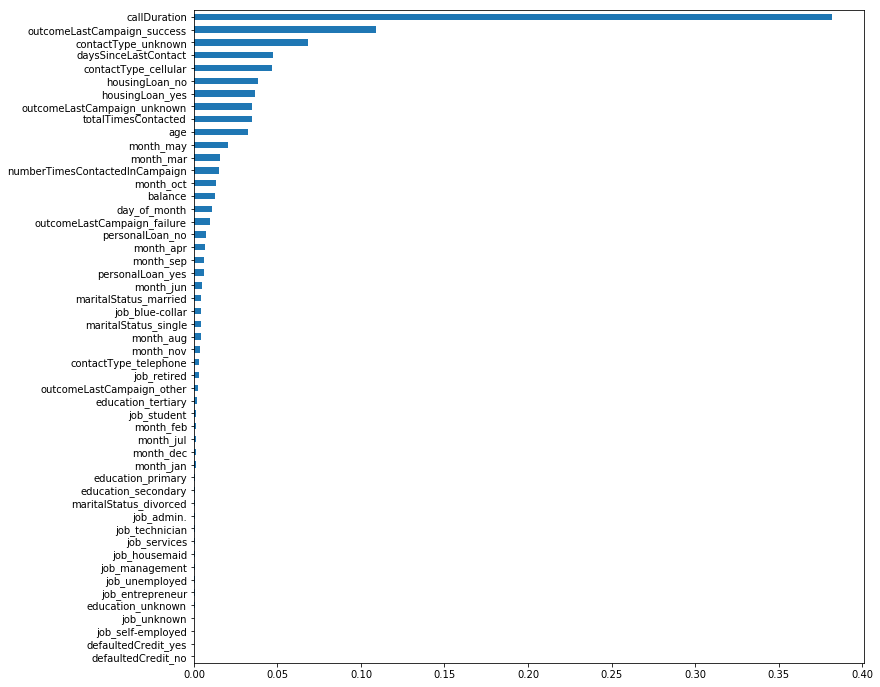

In [115]:
# let's check which variables are the most important to classify the dataset
feature_importances = pd.Series(clf.feature_importances_, index = x.columns)
feature_importances = feature_importances.sort_values()
feature_importances.plot(kind='barh', figsize = (12,12))

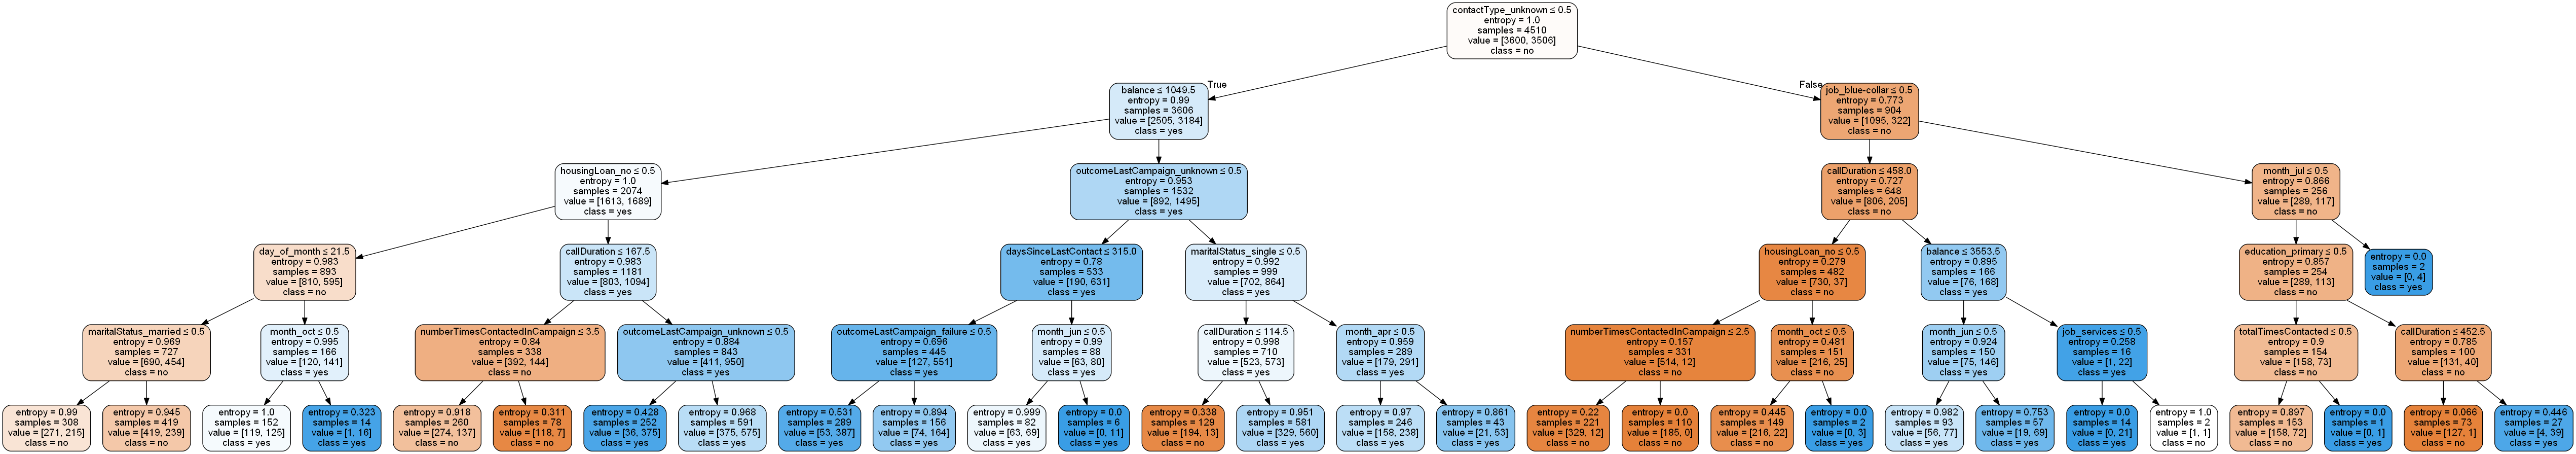

In [120]:
# let's visualise one of the trees of our random forest model
dot_data = StringIO()
estimator = clf.estimators_[90]
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=x_train.columns,class_names=['no', 'yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Going further:
 * Go back through the exercise and remove some of the features that you considered were not affecting the results. Run all of it again with your smaller dataset.
 * Try other models: look at https://www.kaggle.com/rohitgaur/titanic-survivors-classification